In [1]:
GROUP = "Group 27"
COLLABORATORS = ""

---

# DOPP 2019W Exercise 3

- How many of the world’s 1-year-old children today have been vaccinated against some disease? 
- How many against more diseases? 
- How has the rate of vaccination for different diseases changed over time? 
- Are there country characteristics that predict vaccination levels, or trends in vaccination levels?


In [2]:
# Imports

import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# Data Loading

def load_iso3166():
    df = pd.read_csv('datasets/countrycodes.csv')
    df = df[['name', 'alpha-3', 'country-code']]
    df.columns = ['country', 'iso3166', 'country-code']
    return df


def load_dhs():
    df = pd.read_csv('datasets/DHS.csv')
    # take first year for every season (eg. for 2017-18, use 2017)
    df['year'] = df['Survey'].apply(lambda x: int(re.split(r'[ -]', x)[0]))
    # we only want one year olds
    df = df[['Country', 'year', *[col for col in df.columns if col.endswith('12-23')]]]
    df.columns = ['country', 'year', 'BCG', 'DPT1', 'DPT2', 'DPT3', 'POLIO0', 'POLIO1', 'POLIO2', 'POLIO3', 'MEASLES',
                  'all', 'none']
    cc = load_iso3166()
    df = pd.merge(df, cc, left_on='country', right_on='country')
    df.set_index(['iso3166', 'year'], inplace=True)
    return df.drop(columns='country').sort_index()


def load_oecd():
    df = pd.read_csv('datasets/OECD.csv')
    df.columns = ['iso3166', 'x', 'vaccine', 'x', 'x', 'year', 'value', 'x']
    df = df[['iso3166', 'vaccine', 'year', 'value']]
    df = df.pivot_table(index=['iso3166', 'year'], columns='vaccine', values='value')
    return df.sort_index()


def load_england():
    df = pd.read_csv('datasets/england.csv')
    # take first year for every season (eg. for 2017-18, use 2017)
    df['Year'] = df['Year'].apply(lambda x: int(x.split('-')[0]))
    df['iso3166'] = 'GBR'
    df.columns = ['year', 'DTPPH', 'DIPHTERIA', 'TETANUS', 'POLIO', 'PERTUSSIS', 'HIB', 'MMR', 'MENC', 'PCV', 'ROTA',
                  'MENB', 'iso3166']
    df.set_index(['iso3166', 'year'], inplace=True)
    return df.sort_index()


def load_all(add_missing_rows=False):
    dhs = load_dhs()
    oecd = load_oecd()
    oecd.columns = ['DTP', 'MEASLES_']
    eng = load_england()

    df = pd.merge(dhs, oecd, left_index=True, right_index=True, how='outer')
    df = pd.merge(df, eng, left_index=True, right_index=True, how='outer')
    if add_missing_rows:
        df = fill_year(df)

    # take dhs data, and use oecd for missing values if they are present
    df['MEASLES'] = df['MEASLES'].fillna(df['MEASLES_'])

    # combination vaccines
    df['DIPHTERIA'] = df['DIPHTERIA'].fillna(df['DTP']).fillna(df['DPT3']).fillna(df['DTPPH'])
    df['PERTUSSIS'] = df['PERTUSSIS'].fillna(df['DPT3']).fillna(df['DTPPH'])
    df['TETANUS'] = df['TETANUS'].fillna(df['DPT3']).fillna(df['DTPPH'])
    df['POLIO'] = df['POLIO'].fillna(df['POLIO3']).fillna(df['DTP']).fillna(df['DTPPH'])
    df['HIB'] = df['HIB'].fillna(df['DTPPH'])
    df['MEASLES'] = df['MEASLES'].fillna(df['MMR'])

    # Simplify
    df = df[
        ['BCG', 'DIPHTERIA', 'HIB', 'MEASLES', 'MENB', 'MENC', 'MMR', 'PCV', 'PERTUSSIS', 'POLIO', 'ROTA', 'TETANUS',
         'none']]

    # How many have at least one vaccination
    # Use .2 quantile as approximation (some children
    # will not be vaccinated for vacc with min number,
    # but have another vaccination)
    df['some'] = (100 - df['none']).fillna(df.quantile(0.2, axis=1))

    # Filter out data only available for england (-> use england dataset if you need this)
    df = df[['some', 'BCG', 'DIPHTERIA', 'HIB', 'MEASLES', 'PERTUSSIS', 'POLIO', 'TETANUS']]

    dev = load_development_status().set_index('iso3166')['status']
    df = pd.merge(df, dev, left_index=True, right_index=True)

    cens = load_census()
    df = pd.merge(df, cens, left_index=True, right_index=True)

    misc_info = load_country_info().drop(columns=['country', 'country-code'])
    df = pd.merge(df.reset_index(), misc_info, left_on='iso3166', right_on='iso3166').set_index(['iso3166', 'year'])

    religion = load_religion_by_country()
    df = pd.merge(df, religion, left_index=True, right_index=True, how='left')
    df = interpolate_year(df, ["christianity", "judaism", "islam", "buddhism", "zoroastrian", "hindu", "sikh", "shinto",
                               "bahai", "taoism", "jain", "confucianism", "syncretic", "animist", "nonreligious",
                               "otherreligions"])

    return df


def load_development_status():
    # https://unctadstat.unctad.org/EN/Classifications.html
    df = pd.read_csv('datasets/development-status.csv').drop(columns="country")
    cc = load_iso3166()
    df = pd.merge(df, cc, left_on='country-code', right_on='country-code')
    return df


def load_census():
    # http://data.uis.unesco.org/Index.aspx
    df = pd.read_csv('datasets/census_data.csv')
    df = df.drop(columns=["DEMO_IND", "Country", "Time", "Flag Codes", "Flags"])
    df = df.rename(columns={"LOCATION": "iso3166", "TIME": "year"})
    df = pd.pivot_table(df, values="Value", index=["iso3166", "year"], columns="Indicator")
    df.columns = ["Fertility", "GDP", "GDPC", "LifeExpectancy", "MortalityRate", "pop0to14", "pop15to24", "pop25to64",
                  "pop64to99", "popGrowth", "hiv", "ruralPerc", "debtService", "population"]
    df = df.drop(columns="debtService")
    return df


def load_country_info():
    df = pd.read_csv('datasets/countryinfo.csv')
    for col in ['Region', 'Country']:
        df[col] = df[col].apply(lambda x: x.strip())
    for col in ['Pop. Density (per sq. mi.)', 'Coastline (coast/area ratio)', 'Net migration',
                'Infant mortality (per 1000 births)', 'Literacy (%)', 'Phones (per 1000)', 'Arable (%)', 'Crops (%)',
                'Other (%)', 'Climate', 'Birthrate', 'Deathrate', 'Agriculture', 'Industry', 'Service']:
        df[col] = df[col].apply(lambda x: x if type(x) == float else float(x.replace(',', '.')))
    df = pd.merge(df, load_iso3166(), left_on='Country', right_on='country')
    df.columns = ['country', 'region', 'population', 'area', 'pop_density', 'coastline', 'net_migration',
                  'infant_mortality', 'gdp', 'literacy', 'phones', 'arable', 'crops', 'other', 'climate', 'birthrate',
                  'deathrate', 'agriculture', 'industry', 'service', 'x', 'iso3166', 'country-code']
    df.drop(columns=['x'], inplace=True)
    return df


def load_religion_by_region():
    df = pd.read_csv("datasets/religion_regional.csv")
    df = df.drop(
        columns=["chrstprot", "chrstcat", "chrstorth", "chrstang", "chrstothr", "chrstgen", "judorth", "jdcons",
                 "judref", "judothr", "judgen", "islmsun", "islmshi", "islmibd", "islmnat", "islmalw", "islmahm",
                 "islmothr", "islmgen", "budmah", "budthr", "budothr", "budgen", "zorogen", "hindgen", "sikhgen",
                 "shntgen", "bahgen", "taogen", "jaingen", "confgen", "syncgen", "anmgen", "nonrelig", "othrgen",
                 "sumrelig", "pop", "version"])

    df = df[["region", "year", "chrstgenpct", "judgenpct", "islmgenpct", "budgenpct", "zorogenpct", "hindgenpct",
             "sikhgenpct", "shntgenpct", "bahgenpct", "taogenpct", "jaingenpct", "confgenpct", "syncgenpct",
             "anmgenpct", "nonreligpct", "othrgenpct"]]
    df.columns = ["region", "year", "christianity", "judaism", "islam", "buddhism", "zoroastrian", "hindu", "sikh",
                  "shinto", "bahai", "taoism", "jain", "confucianism", "syncretic", "animist", "nonreligious",
                  "otherreligions"]
    df = df.set_index(["region", "year"])

    return df


def load_religion_by_country():
    df = pd.read_csv("datasets/religion_national.csv")
    df = df.drop(
        columns=["chrstprot", "chrstcat", "chrstorth", "chrstang", "chrstothr", "chrstgen", "judorth", "jdcons",
                 "judref", "judothr", "judgen", "islmsun", "islmshi", "islmibd", "islmnat", "islmalw", "islmahm",
                 "islmothr", "islmgen", "budmah", "budthr", "budothr", "budgen", "zorogen", "hindgen", "sikhgen",
                 "shntgen", "bahgen", "taogen", "jaingen", "confgen", "syncgen", "anmgen", "nonrelig", "othrgen",
                 "sumrelig", "pop", "total", "dualrelig", "datatype", "sourcereliab", "recreliab", "reliabilevel",
                 "Version", "sourcecode"])

    df = df[~df["name"].isin(
        ['YUG', 'KOS', 'YPR', 'RVN', 'CYM', 'CXR', 'CCK', 'COK', 'CUW', 'FLK', 'FRO', 'GUF', 'PYF', 'ATF', 'GIB', 'GRL',
         'GLP', 'GUM', 'GGY', 'HMD', 'VAT', 'HKG', 'IMN', 'JEY', 'MTQ', 'MYT', 'MSR', 'NCL', 'NIU', 'NFK', 'MNP', 'PSE',
         'PCN', 'PRI', 'REU', 'BLM', 'SHN', 'MAF', 'SPM', 'SRB', 'SXM', 'SGS', 'SJM', 'TKL', 'TCA', 'UMI', 'VGB', 'VIR',
         'WLF', 'ESH''ALA', 'ASM', 'AIA', 'ATA', 'ABW', 'BMU', 'BES', 'BVT', 'IOT', 'CYM'])]
    df["name"] = df["name"].replace(
        to_replace={'BHM': 'BHS', 'HAI': 'HTI', 'TRI': 'TTO', 'BAR': 'BRB', 'GRN': 'GRD', 'SLU': 'LCA', 'SVG': 'VCT',
                    'AAB': 'ATG', 'SKN': 'KNA',
                    'GUA': 'GTM', 'HON': 'HND', 'SAL': 'SLV', 'COS': 'CRI', 'PAR': 'PRY', 'URU': 'URY', 'UKG': 'GBR',
                    'IRE': 'IRL', 'NTH': 'NLD',
                    'FRN': 'FRA', 'MNC': 'MCO', 'SPN': 'ESP', 'POR': 'PRT', 'GMY': 'DEU', 'GFR': 'DEU', 'GDR': 'DEU',
                    'CZR': 'CZE', 'SLO': 'SVK',
                    'SNM': 'SMR', 'CRO': 'HRV', 'BOS': 'BIH', 'BUL': 'BGR', 'MLD': 'MDA', 'ROM': 'ROU', 'LAT': 'LVA',
                    'LIT': 'LTU', 'GRG': 'GEO', 'SWD': 'SWE', 'DEN': 'DNK', 'ICE': 'ISL', 'CAP': 'CPV', 'EQG': 'GNQ',
                    'GAM': 'GMB', 'MAA': 'MRT',
                    'NIR': 'NER', 'CDI': 'CIV', 'GUI': 'GIN', 'BFO': 'BFA', 'SIE': 'SLE', 'TOG': 'TGO', 'CAO': 'CMR',
                    'NIG': 'NGA', 'CEN': 'CAF',
                    'CHA': 'TCD', 'CON': 'COG', 'DRC': 'COD', 'TAZ': 'TZA', 'BUI': 'BDI', 'ANG': 'AGO', 'MZM': 'MOZ',
                    'ZAM': 'ZMB', 'ZIM': 'ZWE',
                    'MAW': 'MWI', 'SAF': 'ZAF', 'LES': 'LSO', 'BOT': 'BWA', 'SWA': 'SWZ', 'MAG': 'MDG', 'MAS': 'MUS',
                    'SEY': 'SYC', 'MOR': 'MAR',
                    'ALG': 'DZA', 'LIB': 'LBY', 'SUD': 'SDN', 'LEB': 'LBN', 'YAR': 'YEM', 'KUW': 'KWT', 'BAH': 'BHR',
                    'UAE': 'ARE',
                    'OMA': 'OMN', 'TAJ': 'TJK', 'KYR': 'KGZ', 'KZK': 'KAZ', 'MON': 'MNG', 'TAW': 'TWN', 'ROK': 'KOR',
                    'BHU': 'BTN', 'BNG': 'BGD',
                    'MYA': 'MMR', 'SRI': 'LKA', 'MAD': 'MDV', 'NEP': 'NPL', 'THI': 'THA', 'CAM': 'KHM', 'DRV': 'VNM',
                    'MAL': 'MYS',
                    'SIN': 'SGP', 'BRU': 'BRN', 'PHI': 'PHL', 'INS': 'IDN', 'ETM': 'TLS', 'AUL': 'AUS', 'NEW': 'NZL',
                    'VAN': 'VUT', 'SOL': 'SLB',
                    'FIJ': 'FJI', 'NAU': 'NRU', 'MSI': 'MHL', 'PAL': 'PLW', 'MNG': 'MNE', 'AUS': 'AUT', 'MAC': 'MKD',
                    'SLV': 'SVN', 'SWZ': 'CHE'})

    df = df[["name", "year", "chrstgenpct", "judgenpct", "islmgenpct", "budgenpct", "zorogenpct", "hindgenpct",
             "sikhgenpct", "shntgenpct", "bahgenpct", "taogenpct", "jaingenpct", "confgenpct", "syncgenpct",
             "anmgenpct", "nonreligpct", "othrgenpct"]]
    df.columns = ["iso3166", "year", "christianity", "judaism", "islam", "buddhism", "zoroastrian", "hindu", "sikh",
                  "shinto", "bahai", "taoism", "jain", "confucianism", "syncretic", "animist", "nonreligious",
                  "otherreligions"]
    df = df.set_index(["iso3166", "year"])

    return df


def latest_by_country(df):
    dff = df.reset_index()
    dff = pd.merge(dff, dff.groupby(['iso3166'])['year'].max(), left_on=['iso3166', 'year'],
                   right_on=['iso3166', 'year'])
    return dff.set_index('iso3166')


def fill_year(df):
    df = df.reindex(pd.MultiIndex.from_product(
        [df.index.levels[0], np.arange(min(df.index.levels[1]), max(df.index.levels[1] + 1))]), method='ffill')
    df.index.rename(['iso3166', 'year'], inplace=True)
    return df


def interpolate_year(df, columns):
    df = df.reset_index()
    df["date"] = pd.to_datetime(df["year"], format="%Y")
    df = df.set_index("date")
    countries_with_religion = df[df[columns].notna().any(axis=1)]["iso3166"].unique()
    for country in countries_with_religion:
        df.loc[df["iso3166"].eq(country), columns] = df[df["iso3166"].eq(country)][columns].interpolate(method="time")

    df = df.reset_index()
    df = df.drop(columns=["date"])
    return df.set_index(["iso3166", "year"])


def plot_over_year(df, group, agg='mean', plot_column='some', bins=False):
    """
    Bins: either False for no binning or number for number of bins
    """

    if bins:
        df = df.copy()
        df['plot_binned'] = pd.cut(df[group], bins=bins)
        group = 'plot_binned'
    df.groupby(['year', group]).agg({plot_column: [agg]}).unstack(level=1).plot()
    plt.show()


def percentages_on_map(series, title=None, description=None):
    """
    https://ramiro.org/notebook/basemap-choropleth/

    Expects a series of the format
    COUNTRY | VALUE
    --------|------
     AUT    | 73.4
     ...    | ...
    """

    from mpl_toolkits.basemap import Basemap
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection

    map_shape_file = 'plotting/countries/ne_10m_admin_0_countries'
    colors = 9

    cm = plt.get_cmap('Greens')
    scheme = [cm(i / colors) for i in range(colors)]
    bins = np.linspace(series.min(), series.max(), colors)
    df = pd.DataFrame(series)
    df['bin'] = np.digitize(series, bins) - 1

    # plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, frame_on=False)
    fig.suptitle(title, fontsize=30, y=.95)

    m = Basemap(lon_0=0, projection='robin')
    m.drawmapboundary(color='w')

    m.readshapefile(map_shape_file, 'units', color='#444444', linewidth=.2)
    for info, shape in zip(m.units_info, m.units):
        iso3 = info['ADM0_A3']
        if iso3 not in df.index:
            color = '#dddddd'
        else:
            color = scheme[int(df.loc[iso3]['bin'])]

        patches = [Polygon(np.array(shape), True)]
        pc = PatchCollection(patches)
        pc.set_facecolor(color)
        ax.add_collection(pc)

    legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
    cmap = mpl.colors.ListedColormap(scheme)
    cb = mpl.colorbar.ColorbarBase(legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
    cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

    if description is not None:
        plt.annotate(description, xy=(-.8, -3.2), size=14, xycoords='axes fraction')

    fig.show()

## Missing Values in Vaccination Data   

In [93]:
data = load_all()
vacination_types = ['BCG', 'DIPHTERIA', 'HIB', 'MEASLES', 'POLIO', 'TETANUS']

some    BCG  DIPHTERIA  HIB  MEASLES  PERTUSSIS  POLIO  \
iso3166 year                                                            
AFG     2015   86.0   73.0       55.0  NaN     50.6       55.0   62.8   
AGO     2015   79.5   70.2       38.0  NaN     49.6       38.0   39.9   
ALB     2008  100.0  100.0       97.9  NaN     96.8       97.9   99.0   
        2017   99.2   94.5        NaN  NaN      3.4        NaN   93.7   
ARM     2000   94.3   89.5       77.5  NaN      2.3       77.5   85.4   
...             ...    ...        ...  ...      ...        ...    ...   
ZWE     1994   95.1   94.6       80.4  NaN     73.9       80.4   80.3   
        1999   88.2   87.4       77.5  NaN     71.4       77.5   65.5   
        2005   78.0   74.9       54.8  NaN     55.8       54.8   59.0   
        2010   87.5   86.6       70.0  NaN     69.3       70.0   69.3   
        2015   89.9   89.4       82.0  NaN     74.4       82.0   80.9   

              TETANUS         status  Fertility  ...  sikh  shinto   bahai  \
iso3166 year                                     ...                         
AFG     2015     55.0     DEVELOPING      4.802  ...   NaN     NaN     NaN   
AGO     2015     38.0     DEVELOPING      5.766  ...   NaN     NaN     NaN   
ALB     2008     97.9  TRANSITIONING      1.650  ...   NaN     NaN     NaN   
        2017      NaN  TRANSITIONING      1.710  ...   NaN     NaN     NaN   
ARM     2000     77.5  TRANSITIONING      1.648  ...   0.0     0.0  0.0000   
...               ...            ...        ...  ...   ...     ...     ...   
ZWE     1994     80.4     DEVELOPING      4.555  ...   NaN     NaN     NaN   
        1999     77.5     DEVELOPING      4.101  ...   NaN     NaN     NaN   
        2005     54.8     DEVELOPING      3.985  ...   0.0     0.0  0.0016   
        2010     70.0     DEVELOPING      4.028  ...   0.0     0.0  0.0021   
        2015     82.0     DEVELOPING      3.836  ...   0.0     0.0  0.0021   

              taoism  jain  confucianism  syncretic  animist  nonreligious  \
iso3166 year                                                                 
AFG     2015     NaN   NaN           NaN        NaN      NaN           NaN   
AGO     2015     NaN   NaN           NaN        NaN      NaN           NaN   
ALB     2008     NaN   NaN           NaN        NaN      NaN           NaN   
        2017     NaN   NaN           NaN        NaN      NaN           NaN   
ARM     2000     0.0   0.0           0.0     0.0109   0.0000        0.0170   
...              ...   ...           ...        ...      ...           ...   
ZWE     1994     NaN   NaN           NaN        NaN      NaN           NaN   
        1999     NaN   NaN           NaN        NaN      NaN           NaN   
        2005     0.0   0.0           0.0     0.0000   0.1370        0.0204   
        2010     0.0   0.0           0.0     0.0000   0.1354        0.0256   
        2015     0.0   0.0           0.0     0.0000   0.1354        0.0256   

              otherreligions  
iso3166 year                  
AFG     2015             NaN  
AGO     2015             NaN  
ALB     2008             NaN  
        2017             NaN  
ARM     2000          0.0010  
...                      ...  
ZWE     1994             NaN  
        1999             NaN  
        2005          0.0353  
        2010          0.0049  
        2015          0.0049  

[1844 rows x 57 columns]

In [94]:
def nas_per_vac(vac_data, vac_types, statuses, total):
    nas = {}
    
    for status in statuses:
        row = []
        country_count = len(vac_data[vac_data['status'] == status])
        for vac_type in vac_types :
            na_counts = vac_data[vac_data['status'] == status][vac_type].isna().sum()
            if (total):
                row.append(na_counts)
            else:
                row.append(round((na_counts / country_count)*100, 2))
        row.append(country_count)
        nas[status] = row
    
    loc_vac_types = vac_types.copy()
    loc_vac_types.append('country_count')
    return pd.DataFrame.from_dict(nas, orient='index', columns=loc_vac_types)

In [95]:
missing_values_counts_total = nas_per_vac(data, vacination_types, data['status'].unique(), True)
missing_values_counts_total

BCG  DIPHTERIA   HIB  MEASLES  POLIO  TETANUS  country_count
DEVELOPING      396          1   622       10      0      397            622
TRANSITIONING    33          1    46        0      0       34             46
DEVELOPED      1176         17  1152       31     17     1152           1176

In [96]:
missing_values_counts_perc = nas_per_vac(data, vacination_types, data['status'].unique(), False)
missing_values_counts_perc

BCG  DIPHTERIA     HIB  MEASLES  POLIO  TETANUS  \
DEVELOPING      63.67       0.16  100.00     1.61   0.00    63.83   
TRANSITIONING   71.74       2.17  100.00     0.00   0.00    73.91   
DEVELOPED      100.00       1.45   97.96     2.64   1.45    97.96   

               country_count  
DEVELOPING               622  
TRANSITIONING             46  
DEVELOPED               1176

# Vaccination Rates Over Time by Country Status

In [97]:
def data_prep_status_analysis(all_data):
    all_data.set_index(['status'], append=True, inplace= True)
    aggregation = all_data.median(level = ['year', 'status'])
    aggregation.sort_index(inplace=True)
    aggregation = aggregation.reset_index()
    aggregation.set_index(['year'], inplace= True)
    # Calculating median vaccination rate per row
    aggregation['vac_mean'] = aggregation[vacination_types].mean(axis=1)
    return aggregation

In [98]:
vaccination_types_mean = ['BCG', 'DIPHTERIA', 'HIB', 'MEASLES', 'POLIO', 'TETANUS', 'vac_mean']
styles = ['','','','','','','.:']
aggregation_per_year_status = data_prep_status_analysis(load_all())

## Vaccination Rates from (1980 - 2018)
This plot shows no clear trends.

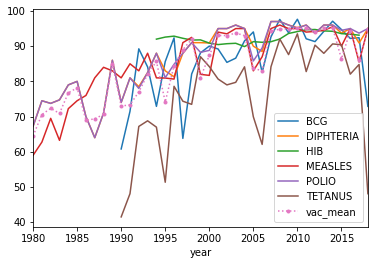

In [99]:
aggregation_per_year_status.median(level = ['year'])[vaccination_types_mean].plot(style=styles)

### Vaccination Rates in developed countries (1980 - 2018)

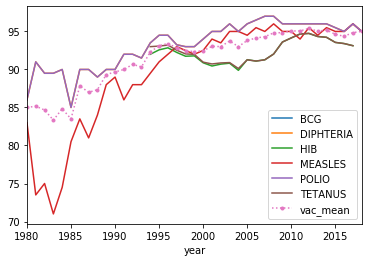

In [100]:
aggregation_per_year_status[aggregation_per_year_status['status'] == 'DEVELOPED'][vaccination_types_mean].plot(style=styles)

### Vaccination Rates in developing countries (1980 - 2018)

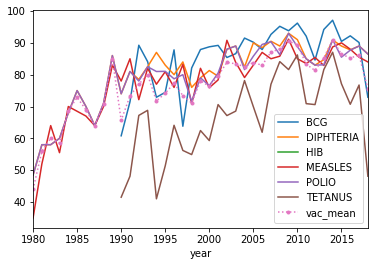

In [101]:
aggregation_per_year_status[aggregation_per_year_status['status'] == 'DEVELOPING'][vaccination_types_mean].plot(style=styles)

### Vaccination Rates in transitioning countries (1986 - 2018)

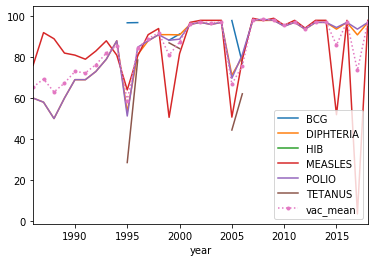

In [102]:
aggregation_per_year_status[aggregation_per_year_status['status'] == 'TRANSITIONING'][vaccination_types_mean].plot(style=styles)

### Mean Vaccination Rates per Country Status (1980 - 2018)

In [103]:
def seperate_to_col_by_status(mean_vaccinations, statuses):
    status_map = {}
    
    for status in statuses:
        status_map[status] = mean_vaccinations[mean_vaccinations['status'] == status]['vac_mean']
    
    df =  pd.DataFrame.from_dict(status_map, orient='index')
    
    return df.transpose()
    

In [ ]:
mean_vaccinations = aggregation_per_year_status[['status', 'vac_mean']]
seperate_to_col_by_status(mean_vaccinations, mean_vaccinations['status'].unique()).plot()

In [ ]:
## Example MEASLES, POLIO, DIPHTERIA
The following plots will focus on measles, polio and diphteria since those datasets are the ones with the least missing values. 

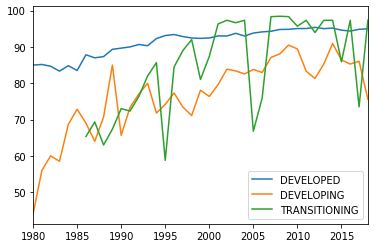

In [109]:
## Example MEASLES, POLIO, DIPHTERIA
The following plots will focus on measles, polio and diphteria since those datasets are the ones with the least missing values. 

## Example MEASLES, POLIO, DIPHTERIA
The following plots will focus on measles, polio and diphteria since those datasets are the ones with the least missing values. 

In [18]:
vaccination_types_reduced = ['MEASLES', 'POLIO', 'DIPHTERIA']
def reduced_data_prep(aggregation_full):
    aggregation_reduced = aggregation_full[['status', 'MEASLES', 'POLIO', 'DIPHTERIA']]
    # Calculating median vaccination rate per row
    aggregation_reduced['vac_mean'] = aggregation_reduced[vaccination_types_reduced].mean(axis=1)
    return aggregation_reduced

In [19]:
aggregation_per_year_status_reduced = reduced_data_prep(aggregation_per_year_status)

/Library/Python/3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


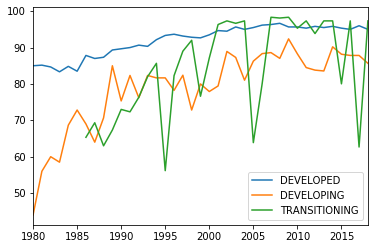

In [20]:
seperate_to_col_by_status(aggregation_per_year_status_reduced, aggregation_per_year_status_reduced['status'].unique()).plot()
